In [1]:
import uproot
import glob
import pandas as pd
import warnings
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import yahist
import itertools
import mplhep as hep
import xgboost as xgb #BDT
import pickle

plt.rcParams.update({"figure.facecolor":  (1,1,1,0)})

from utils.analysis import Optimization, PandasAnalysis

TAG = "abcdnet_v2"
PLOTSDIR = f"/home/users/jguiang/public_html/vbsvvhjets_plots/{TAG}/opt"

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
babies = sorted(glob.glob(f"../analysis/studies/vbsvvhjets/output_{TAG}/Run2/inferences/*.root"))
sig_babies = [baby for baby in babies if "VBSVVH" in baby]
bkg_babies = [baby for baby in babies if "VBS" not in baby and "data" not in baby]
data_babies = [baby for baby in babies if "data" in baby]
print("Signal:")
print("\n".join(sig_babies))
print("Background:")
print("\n".join(bkg_babies))
print("Data:")
print("\n".join(data_babies))

Signal:
../analysis/studies/vbsvvhjets/output_abcdnet_v2/Run2/inferences/VBSVVH.root
Background:
../analysis/studies/vbsvvhjets/output_abcdnet_v2/Run2/inferences/Bosons.root
../analysis/studies/vbsvvhjets/output_abcdnet_v2/Run2/inferences/QCD.root
../analysis/studies/vbsvvhjets/output_abcdnet_v2/Run2/inferences/SingleTop.root
../analysis/studies/vbsvvhjets/output_abcdnet_v2/Run2/inferences/TT1L.root
../analysis/studies/vbsvvhjets/output_abcdnet_v2/Run2/inferences/TTH.root
../analysis/studies/vbsvvhjets/output_abcdnet_v2/Run2/inferences/TTHad.root
../analysis/studies/vbsvvhjets/output_abcdnet_v2/Run2/inferences/TTW.root
Data:
../analysis/studies/vbsvvhjets/output_abcdnet_v2/Run2/inferences/data.root


In [3]:
vbsvvh = Optimization(
    sig_root_files=sig_babies,
    bkg_root_files=bkg_babies,
    data_root_files=data_babies,
    ttree_name="tree",
    weight_columns=[
        "xsec_sf", 
        "pu_sf", 
        "prefire_sf", 
#         "xwqq_ld_vqq_sf", 
#         "xwqq_tr_vqq_sf",
    ],
    plots_dir=PLOTSDIR,
    sample_labels = {
        "VBSVVH": r"VBS VVH $(C_{2V} = 2)$", 
        "TTHad": r"$t\bar{t}+$jets",
        "TT1L": r"$t\bar{t}+1\ell$",
        "QCD": "QCD",
        "SingleTop": r"Single $t$",
        "TTH": r"$t\bar{t}+H$",
        "TTW": r"$t\bar{t}+W$",
    },
#     reweight_column="reweights"
)

vbsvvh.df["objsel"] = True
vbsvvh.df["presel"] = vbsvvh.df.eval(
    "objsel and hbbfatjet_xbb > 0.5 and ld_vqqfatjet_xwqq > 0.3 and tr_vqqfatjet_xwqq > 0.3"
)
vbsvvh.make_selection("presel")

bkg_count = vbsvvh.bkg_count()
qcd_count = vbsvvh.sample_count("QCD")
data_count = vbsvvh.data_count()

vbsvvh.df.loc[vbsvvh.df.name == "QCD", "event_weight"] *= (data_count - (bkg_count - qcd_count))/(qcd_count)

ORIG_EVENT_WEIGHT = vbsvvh.df.event_weight.values.copy()

Loading data babies: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


In [4]:
with uproot.open(f"../analysis/studies/vbsvvhjets/output_{TAG}/Run2/VBSVVH.root") as f:
    reweights = np.stack(f["rwgt_tree"].arrays(library="np")["reweights"])
    reweights = np.insert(reweights, 28, 1, axis=1)
    n_events, n_reweights = reweights.shape
    
with open("../analysis/data/VBSVVH_reweights.txt", "r") as f_in:
    reweight_names = f_in.read().splitlines()
    
def get_reweights(CV="1", C2V="1", C3="1"):
    CV = CV.replace(".", "p").replace("-", "m")
    C2V = C2V.replace(".", "p").replace("-", "m")
    C3 = C3.replace(".", "p").replace("-", "m")
    
    reweight_name = f"scan_CV_{CV}_C2V_{C2V}_C3_{C3}"
    if reweight_name in reweight_names:
        reweight_i = reweight_names.index(reweight_name)
        return reweights.T[reweight_i]
    else:
        print(f"WARNING: reweight {reweight_name} not found, returning 1")
        return np.ones(n_reweights)
    
reweights.shape

(18499, 37)

In [5]:
def plot_multiple_C2Vs(column, bins, C2Vs=[], x_label=None, selection=None, logy=False,
                       legend_loc=None, legend_ncols=1,
                       sig_scale=1, save=True, y_lim=(None, None), x_lim=(None, None)):

    axes = vbsvvh.plot_sig_vs_bkg(
        column, bins, 
        selection=selection,
        x_label=x_label,
        stacked=True,
        sig_scale=sig_scale,
        logy=logy,
        legend_loc="upper left"
    );

    for C2V in C2Vs:
        vbsvvh.df["reweight"] = 1
        vbsvvh.df.loc[vbsvvh.df.is_signal, "reweight"] = get_reweights(CV="1.0", C2V=C2V, C3="1.0")
        sig_df = vbsvvh.sig_df(selection=selection)
        axes.hist(
            sig_df[column],
            bins=bins,
            weights=sig_df.event_weight*sig_df.reweight,
            histtype="step",
            label=f"C2V = {C2V} [{np.sum(sig_df.event_weight*sig_df.reweight):.1f} events]",
            linewidth=2
        );

    axes.legend(fontsize=14, loc=legend_loc, ncol=legend_ncols);
    
    left, right = x_lim
    if not left is None:
        axes.set_xlim(left=left)
    if not right is None:
        axes.set_xlim(right=right)
        
    top, bottom = y_lim
    if not top is None:
        axes.set_ylim(top=top)
    if not bottom is None:
        axes.set_ylim(bottom=bottom)
        
    
    plot_file = f"{PLOTSDIR}/{column}_sig_vs_bkg.pdf"
    plot_file = plot_file.replace(".pdf", "_stacked.pdf")
    if logy:
        plot_file = plot_file.replace(".pdf", "_logy.pdf")
    if selection:
        plot_file = plot_file.replace(".pdf", f"_{PandasAnalysis.get_selection_str(selection)}.pdf")
        
    if save:
        plt.savefig(plot_file, bbox_inches="tight")
        plt.savefig(plot_file.replace(".pdf", ".png"), bbox_inches="tight")
    
    return axes, plot_file

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v2/opt/HT_fat_sig_vs_bkg_stacked_logy.pdf


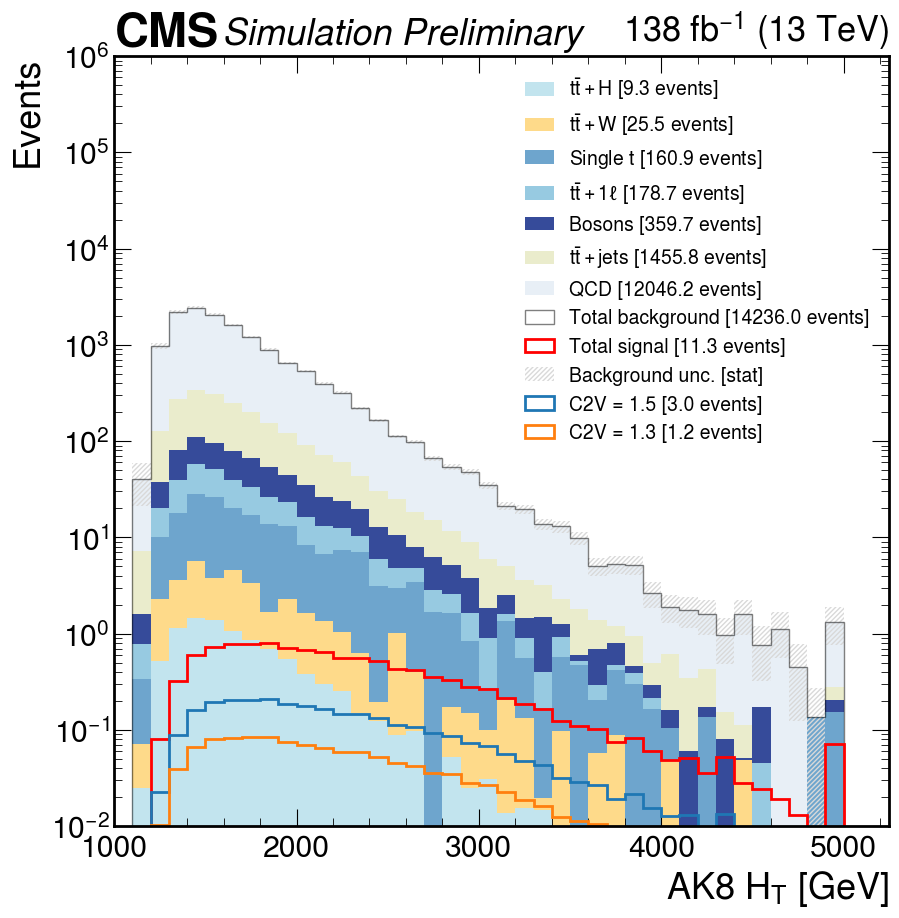

In [6]:
axes, plot_file = plot_multiple_C2Vs(
    "HT_fat", np.linspace(0, 5000, 51), 
    C2Vs=["1.5", "1.3"],
    x_label=r"AK8 $H_{T}$ [GeV]", 
    logy=True, legend_loc="upper right",
    x_lim=(1000, None), y_lim=(1e6, None),
    save=True
);

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v2/opt/M_jj_sig_vs_bkg_stacked_logy.pdf


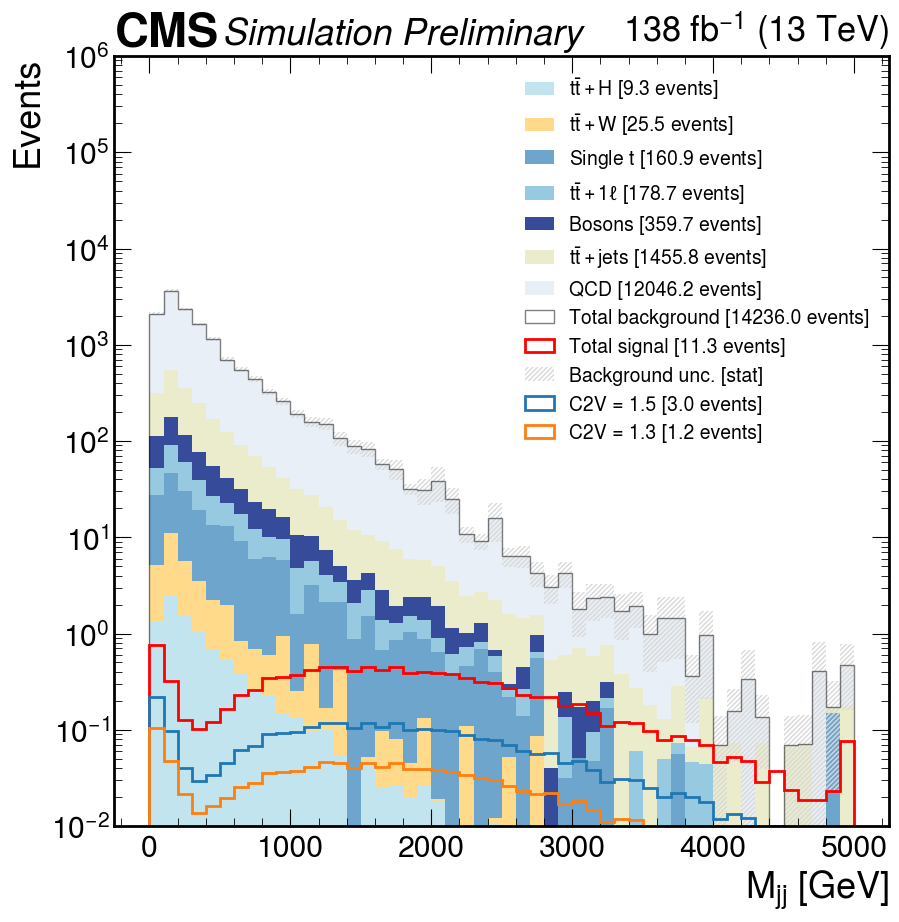

In [7]:
axes, plot_file = plot_multiple_C2Vs(
    "M_jj", np.linspace(0, 5000, 51), 
    C2Vs=["1.5", "1.3"],
    x_label=r"$M_{jj}$ [GeV]", 
    logy=True, legend_loc="upper right",
    x_lim=(None, None), y_lim=(1e6, None),
    save=True
);

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v2/opt/abs_deta_jj_sig_vs_bkg_stacked_logy.pdf


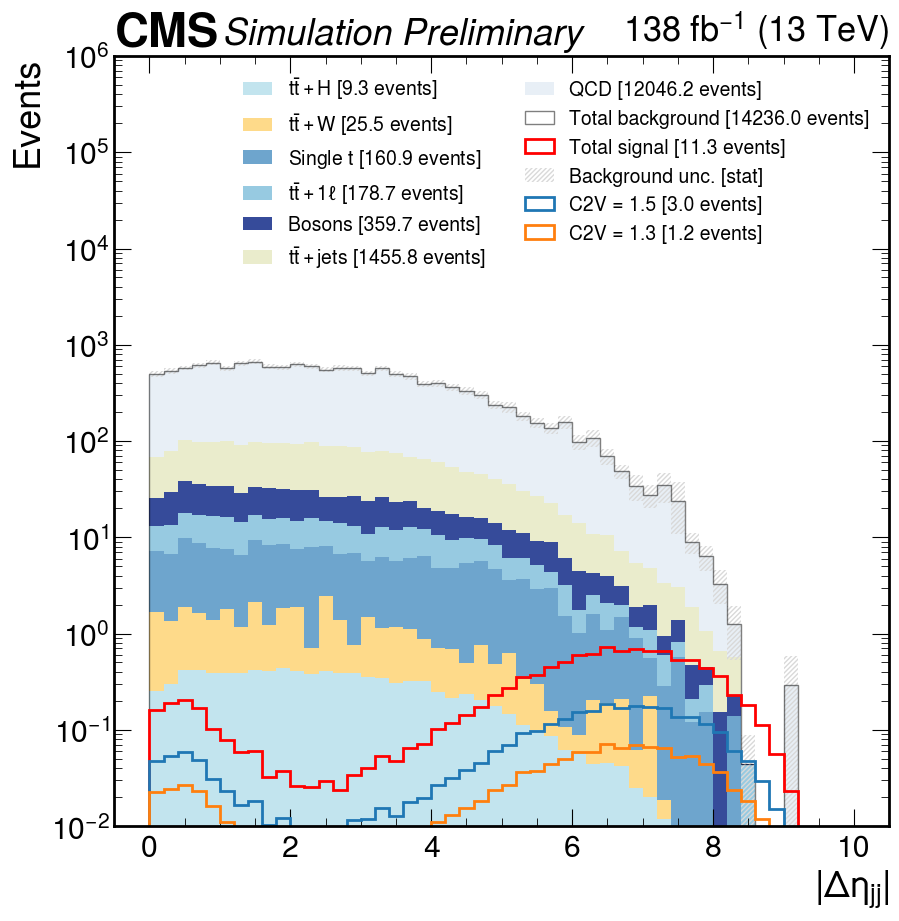

In [8]:
axes, plot_file = plot_multiple_C2Vs(
    "abs_deta_jj", np.linspace(0, 10, 51), 
    C2Vs=["1.5", "1.3"],
    x_label=r"$|\Delta\eta_{jj}|$", 
    logy=True, legend_loc="upper right",
    x_lim=(None, None), y_lim=(1e6, None),
    save=True, legend_ncols=2
);

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v2/opt/hbbfatjet_pt_sig_vs_bkg_stacked_logy.pdf


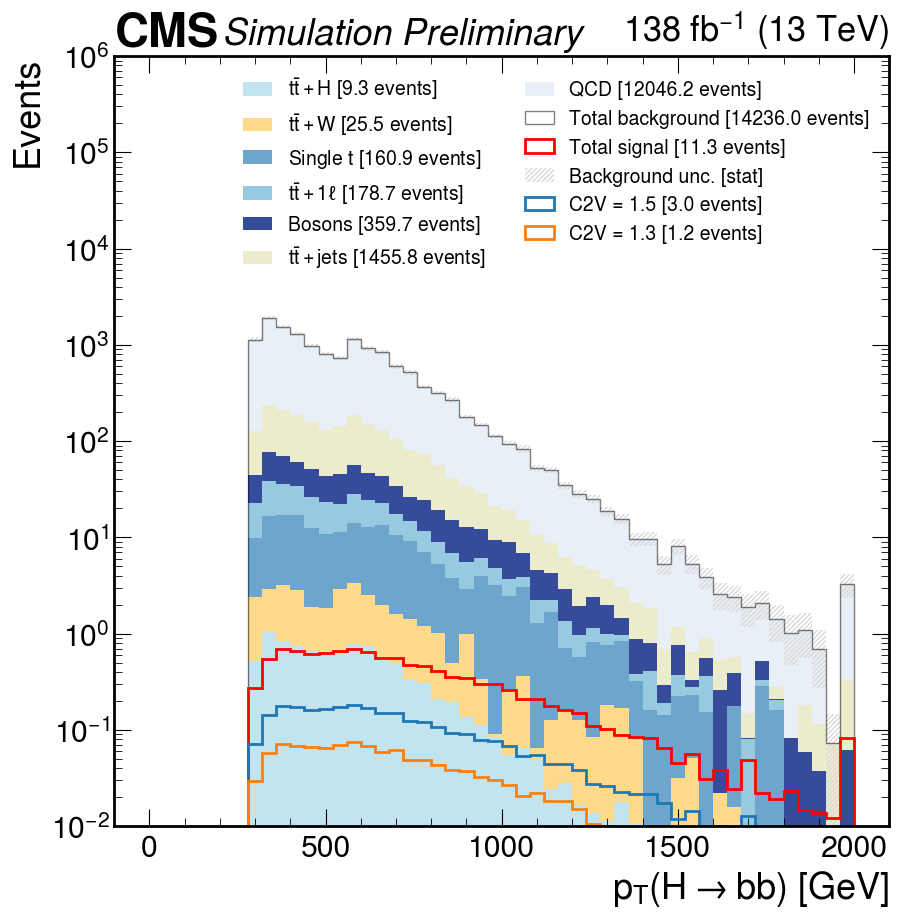

In [9]:
axes, plot_file = plot_multiple_C2Vs(
    "hbbfatjet_pt", np.linspace(0, 2000, 51), 
    C2Vs=["1.5", "1.3"],
    x_label=r"$p_T(H\rightarrow bb)$ [GeV]", 
    logy=True, legend_loc="upper right",
    x_lim=(None, None), y_lim=(1e6, None),
    save=True, legend_ncols=2
);

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v2/opt/hbbfatjet_mass_sig_vs_bkg_stacked_logy.pdf


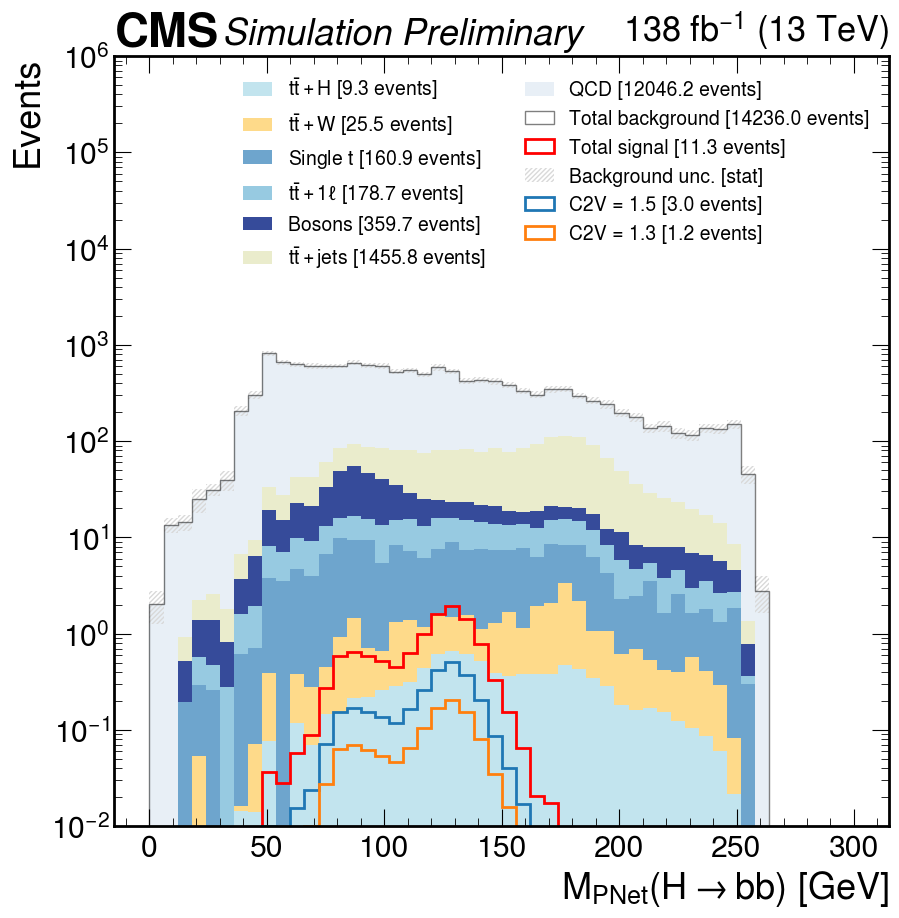

In [10]:
axes, plot_file = plot_multiple_C2Vs(
    "hbbfatjet_mass", np.linspace(0, 300, 51), 
    C2Vs=["1.5", "1.3"],
    x_label=r"$M_{PNet}(H\rightarrow bb)$ [GeV]", 
    logy=True, legend_loc="upper right",
    x_lim=(None, None), y_lim=(1e6, None),
    save=True, legend_ncols=2
);

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v2/opt/ld_vqqfatjet_pt_sig_vs_bkg_stacked_logy.pdf


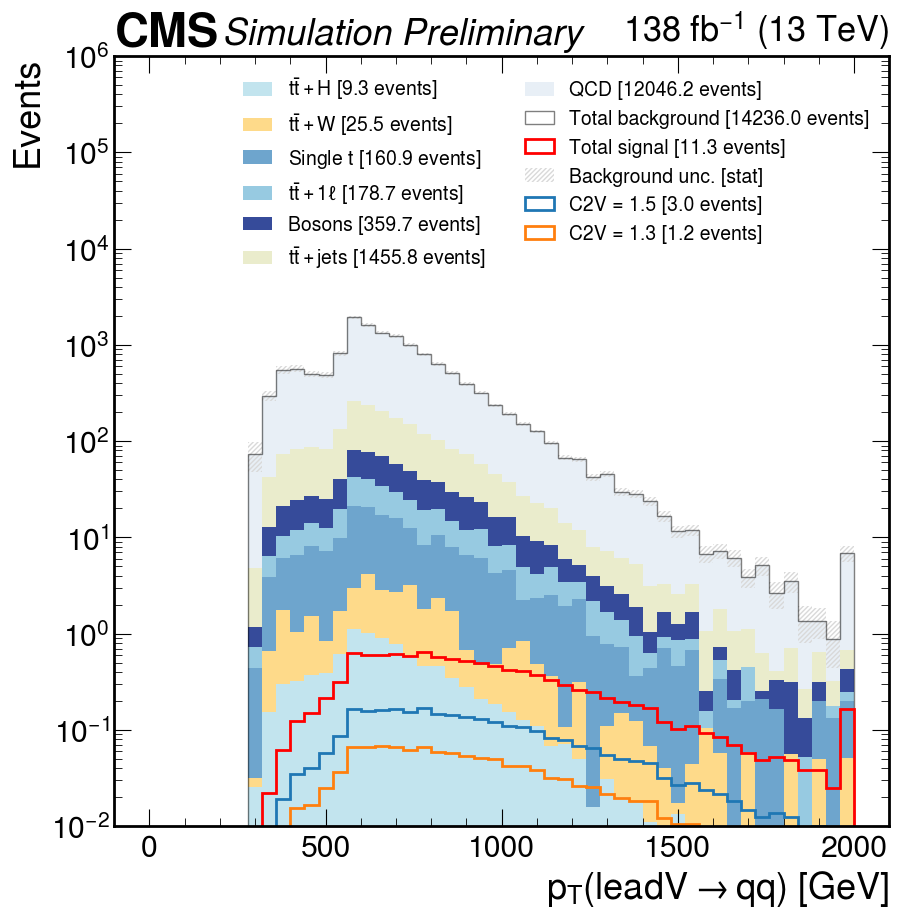

In [11]:
axes, plot_file = plot_multiple_C2Vs(
    "ld_vqqfatjet_pt", np.linspace(0, 2000, 51), 
    C2Vs=["1.5", "1.3"],
    x_label=r"$p_T(lead V\rightarrow qq)$ [GeV]", 
    logy=True, legend_loc="upper right",
    x_lim=(None, None), y_lim=(1e6, None),
    save=True, legend_ncols=2
);

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v2/opt/ld_vqqfatjet_mass_sig_vs_bkg_stacked_logy.pdf


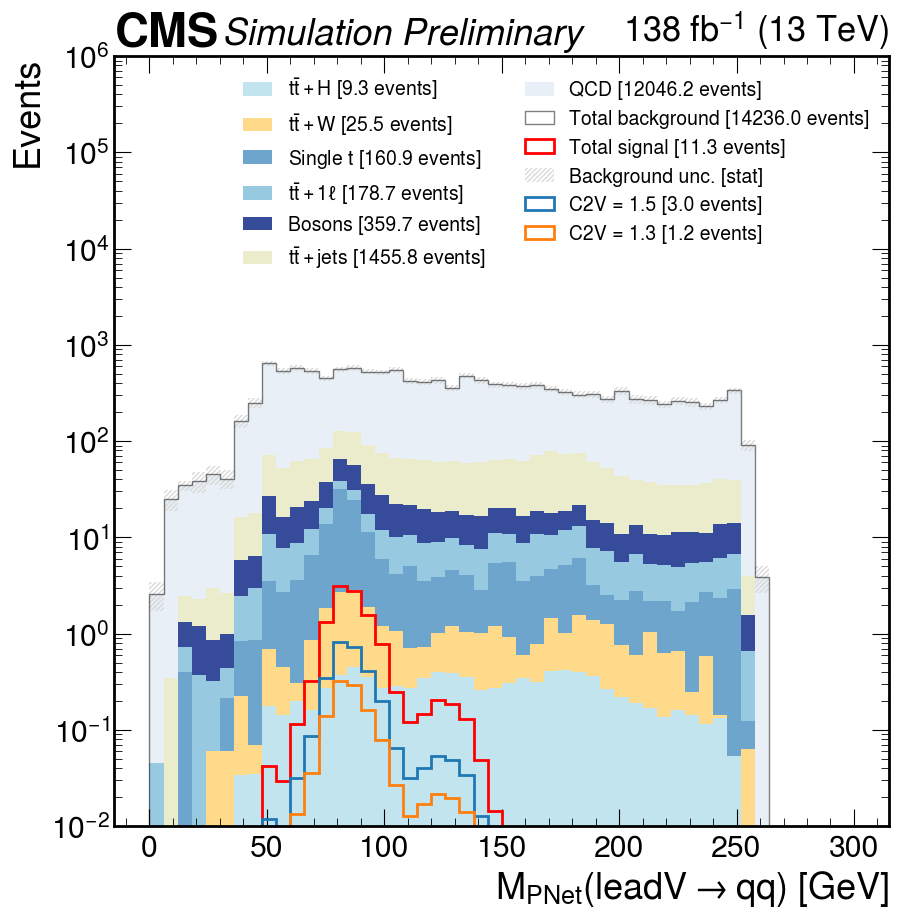

In [12]:
axes, plot_file = plot_multiple_C2Vs(
    "ld_vqqfatjet_mass", np.linspace(0, 300, 51), 
    C2Vs=["1.5", "1.3"],
    x_label=r"$M_{PNet}(lead V\rightarrow qq)$ [GeV]", 
    logy=True, legend_loc="upper right",
    x_lim=(None, None), y_lim=(1e6, None),
    save=True, legend_ncols=2
);

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v2/opt/tr_vqqfatjet_pt_sig_vs_bkg_stacked_logy.pdf


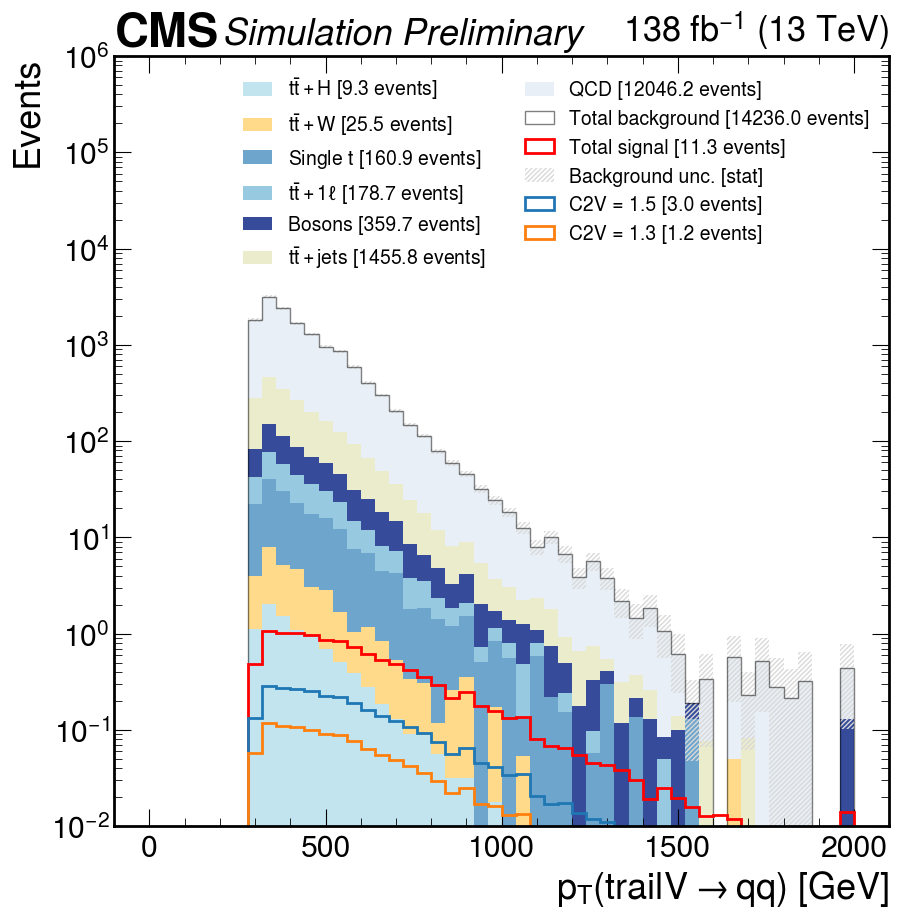

In [13]:
axes, plot_file = plot_multiple_C2Vs(
    "tr_vqqfatjet_pt", np.linspace(0, 2000, 51), 
    C2Vs=["1.5", "1.3"],
    x_label=r"$p_T(trail V\rightarrow qq)$ [GeV]", 
    logy=True, legend_loc="upper right",
    x_lim=(None, None), y_lim=(1e6, None),
    save=True, legend_ncols=2
);

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v2/opt/tr_vqqfatjet_mass_sig_vs_bkg_stacked_logy.pdf


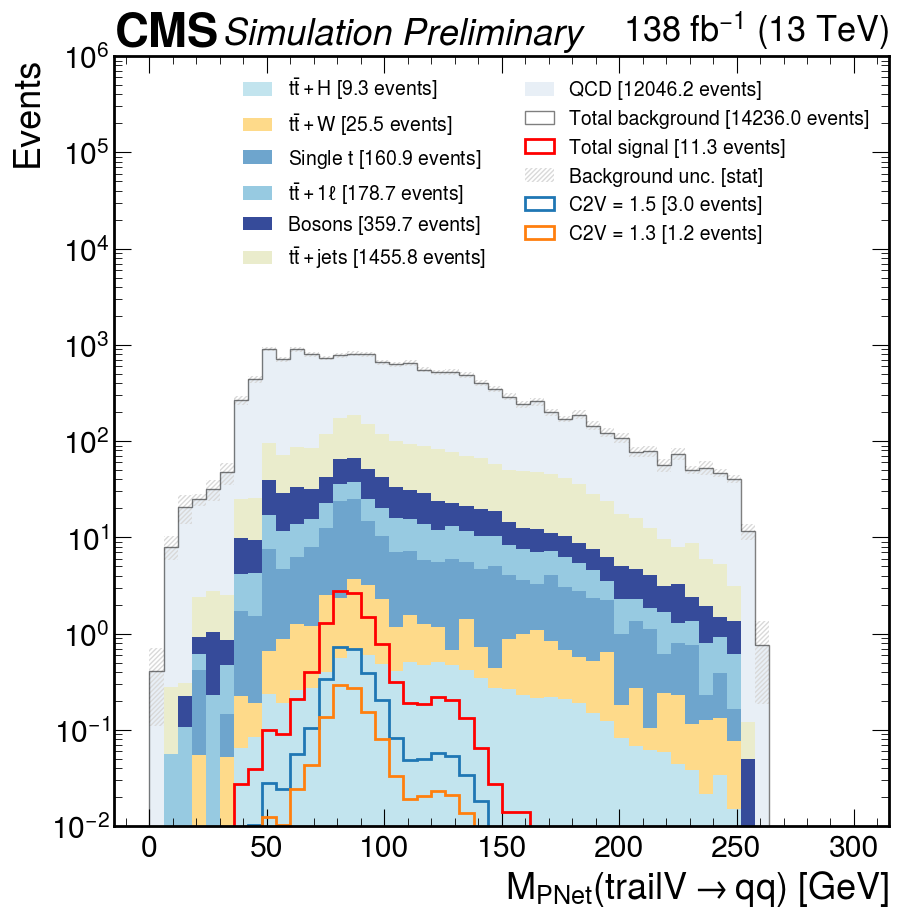

In [14]:
axes, plot_file = plot_multiple_C2Vs(
    "tr_vqqfatjet_mass", np.linspace(0, 300, 51), 
    C2Vs=["1.5", "1.3"],
    x_label=r"$M_{PNet}(trail V\rightarrow qq)$ [GeV]", 
    logy=True, legend_loc="upper right",
    x_lim=(None, None), y_lim=(1e6, None),
    save=True, legend_ncols=2
);

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v2/opt/abcdnet_score_sig_vs_bkg_stacked_logy.pdf


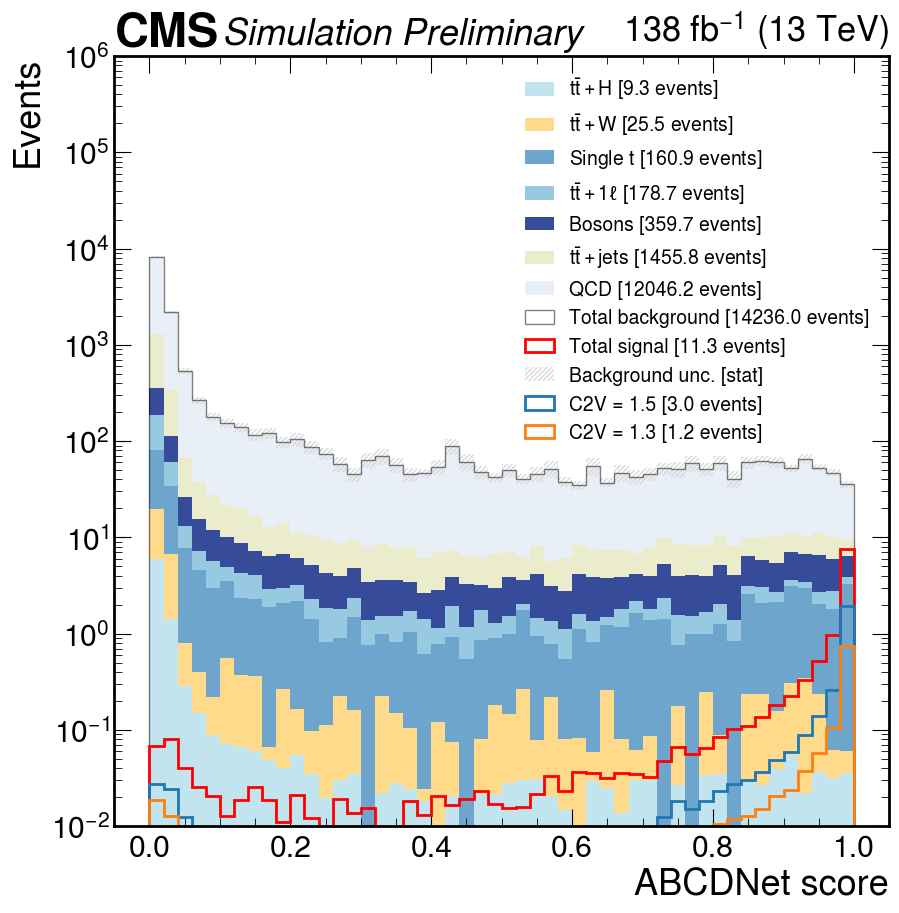

In [15]:
axes, plot_file = plot_multiple_C2Vs(
    "abcdnet_score", np.linspace(0, 1, 51), 
    C2Vs=["1.5", "1.3"],
    x_label=r"ABCDNet score", 
    logy=True, legend_loc="upper right",
    x_lim=(None, None), y_lim=(1e6, None),
    save=True
);

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v2/opt/correlation2D_abcdnet_score_abs_deta_jj_1Dprofile.pdf


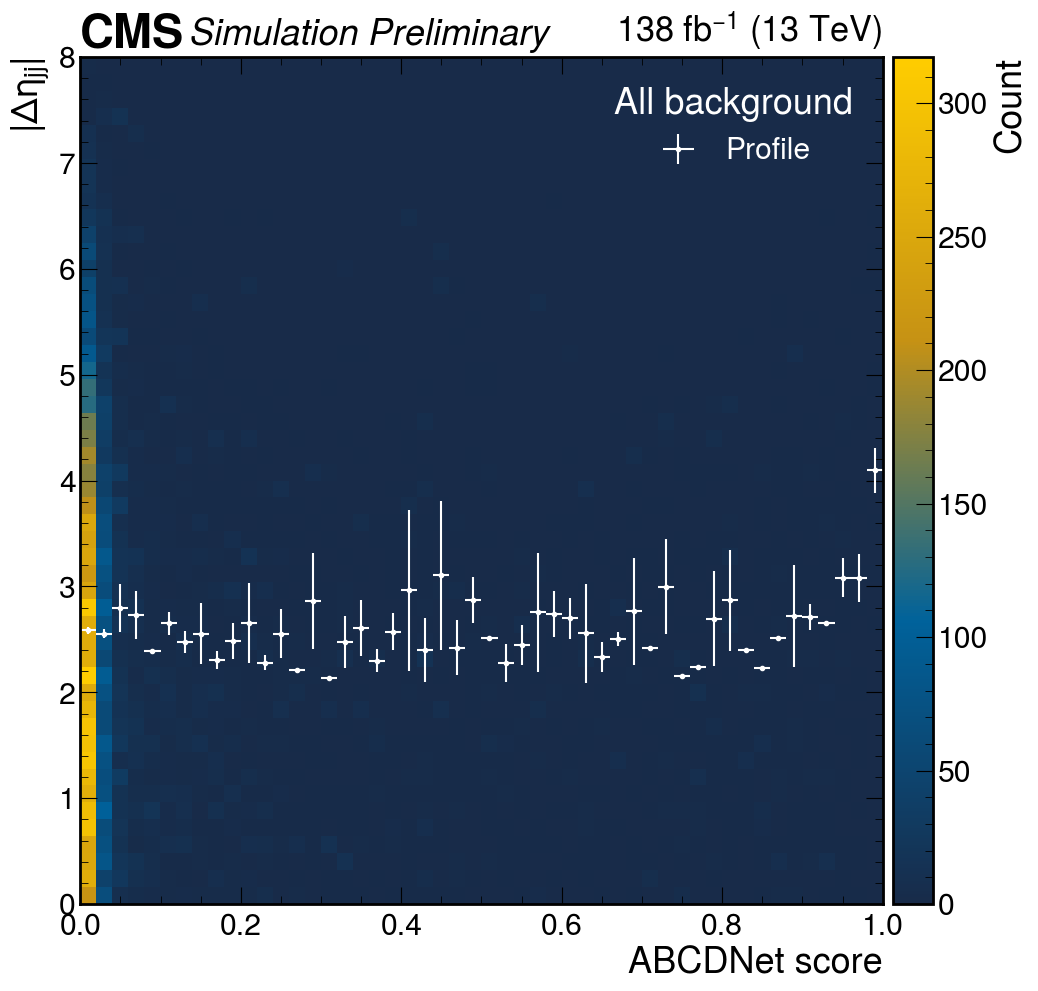

In [16]:
vbsvvh.plot_correlation2D(
    "abcdnet_score", "abs_deta_jj", 
    np.linspace(0, 1,51), np.linspace(0, 8,51),
    flip=False,
    x_label=r"ABCDNet score",
    y_label=r"$|\Delta\eta_{jj}|$"
)

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v2/opt/correlation2D_abcdnet_score_abs_deta_jj_1Dprofile_flipped.pdf


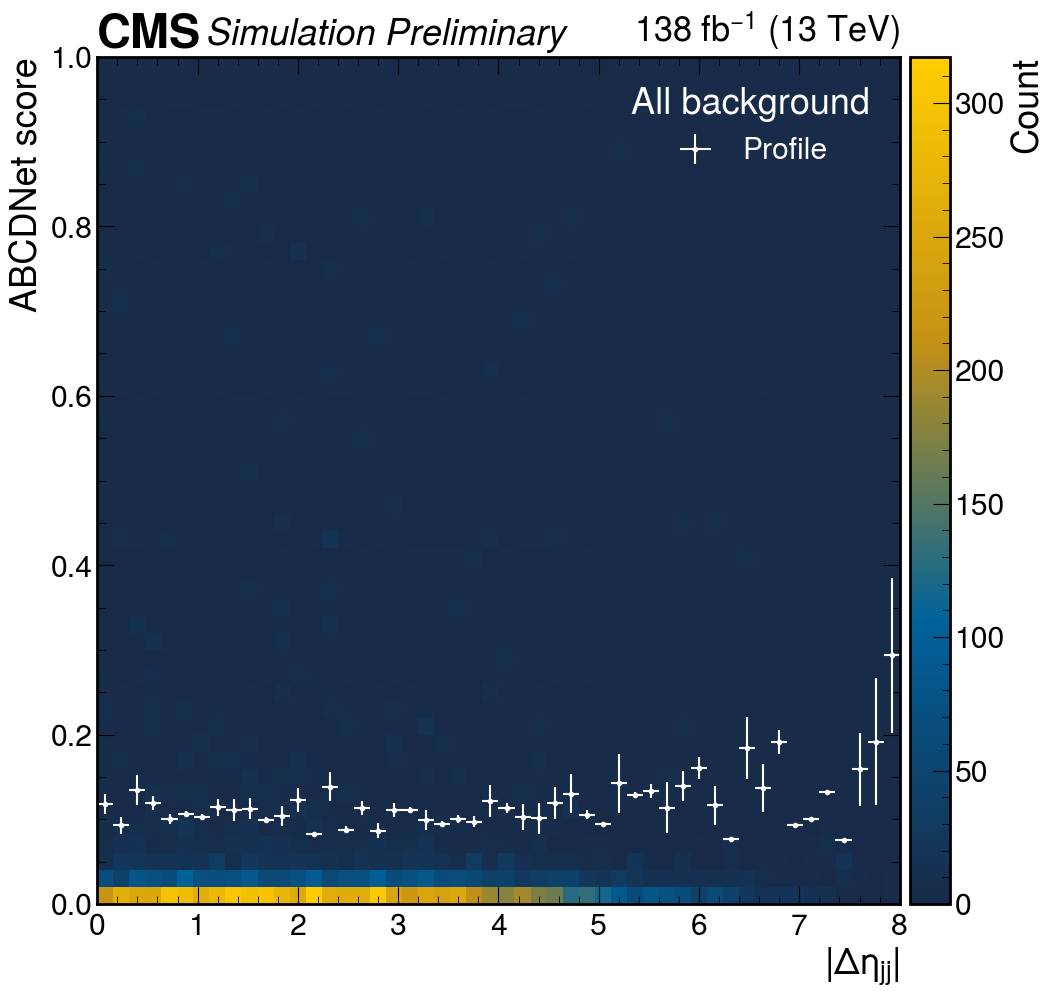

In [17]:
vbsvvh.plot_correlation2D(
    "abcdnet_score", "abs_deta_jj", 
    np.linspace(0, 1, 51), np.linspace(0, 8, 51),
    flip=True,
    x_label=r"ABCDNet score",
    y_label=r"$|\Delta\eta_{jj}|$"
)

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v2/opt/correlation2D_abcdnet_score_abs_deta_jj_1Dprofile.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v2/opt/correlation2D_abcdnet_score_abs_deta_jj_1Dprofile_flipped.pdf


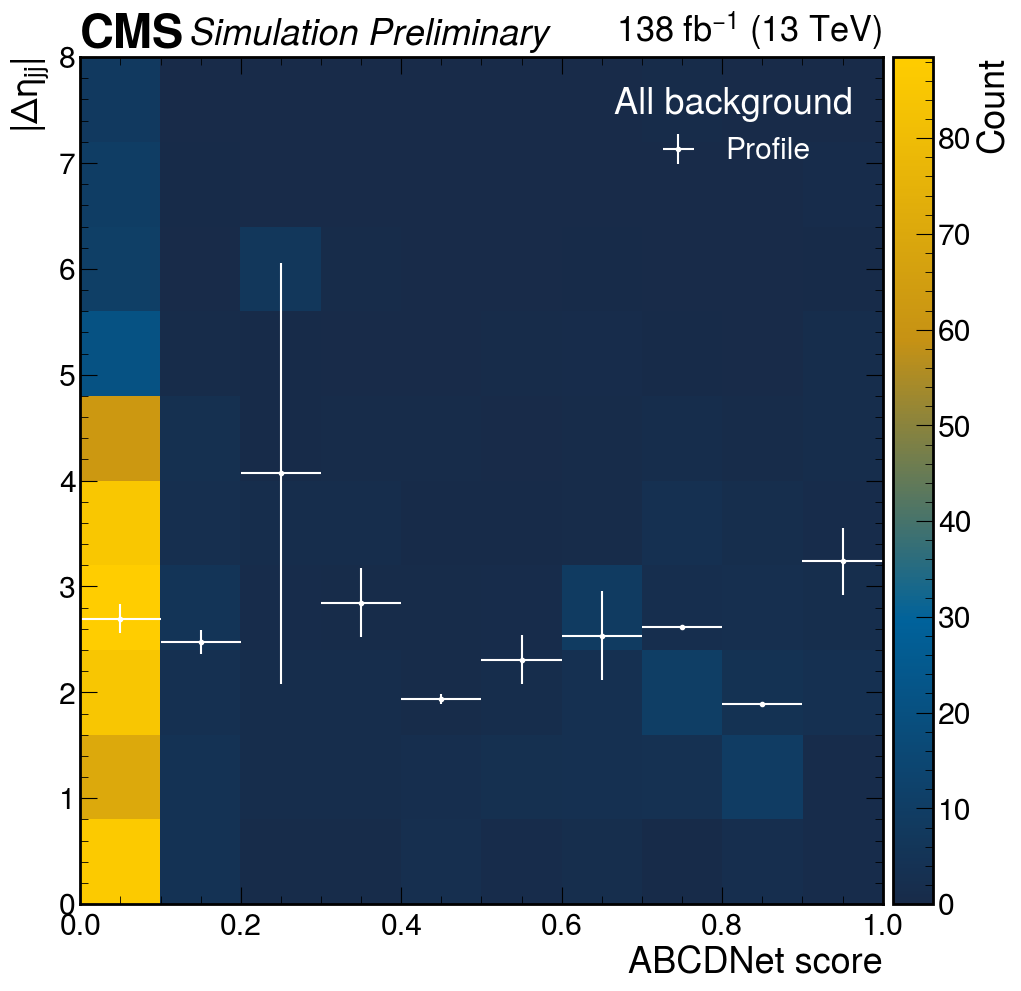

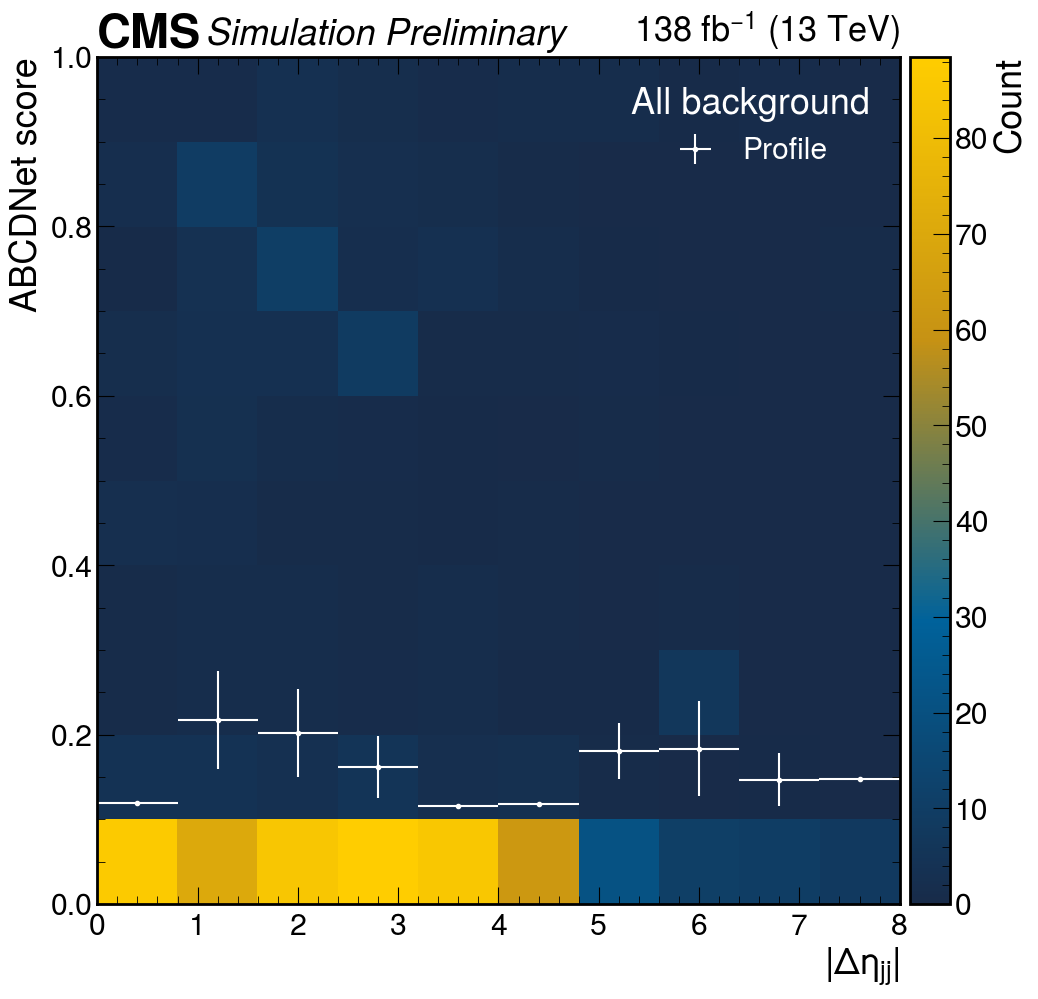

In [18]:
vbsvvh.df.event_weight *= vbsvvh.df.xbb_sf*vbsvvh.df.xwqq_ld_vqq_sf*vbsvvh.df.xwqq_tr_vqq_sf

vbsvvh.plot_correlation2D(
    "abcdnet_score", "abs_deta_jj", 
    np.linspace(0, 1, 11), np.linspace(0, 8, 11),
    sel="presel and hbbfatjet_xbb > 0.8 and ld_vqqfatjet_xwqq > 0.8 and tr_vqqfatjet_xwqq > 0.7",
    flip=False,
    x_label=r"ABCDNet score",
    y_label=r"$|\Delta\eta_{jj}|$"
)

vbsvvh.plot_correlation2D(
    "abcdnet_score", "abs_deta_jj", 
    np.linspace(0, 1, 11), np.linspace(0, 8, 11),
    sel="presel and hbbfatjet_xbb > 0.8 and ld_vqqfatjet_xwqq > 0.8 and tr_vqqfatjet_xwqq > 0.7",
    flip=True,
    x_label=r"ABCDNet score",
    y_label=r"$|\Delta\eta_{jj}|$"
)

vbsvvh.df.event_weight = ORIG_EVENT_WEIGHT

Wrote to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v2/opt/abcdnet_roc.pdf
Wrote to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v2/opt/abcdnet_roc_logx.pdf


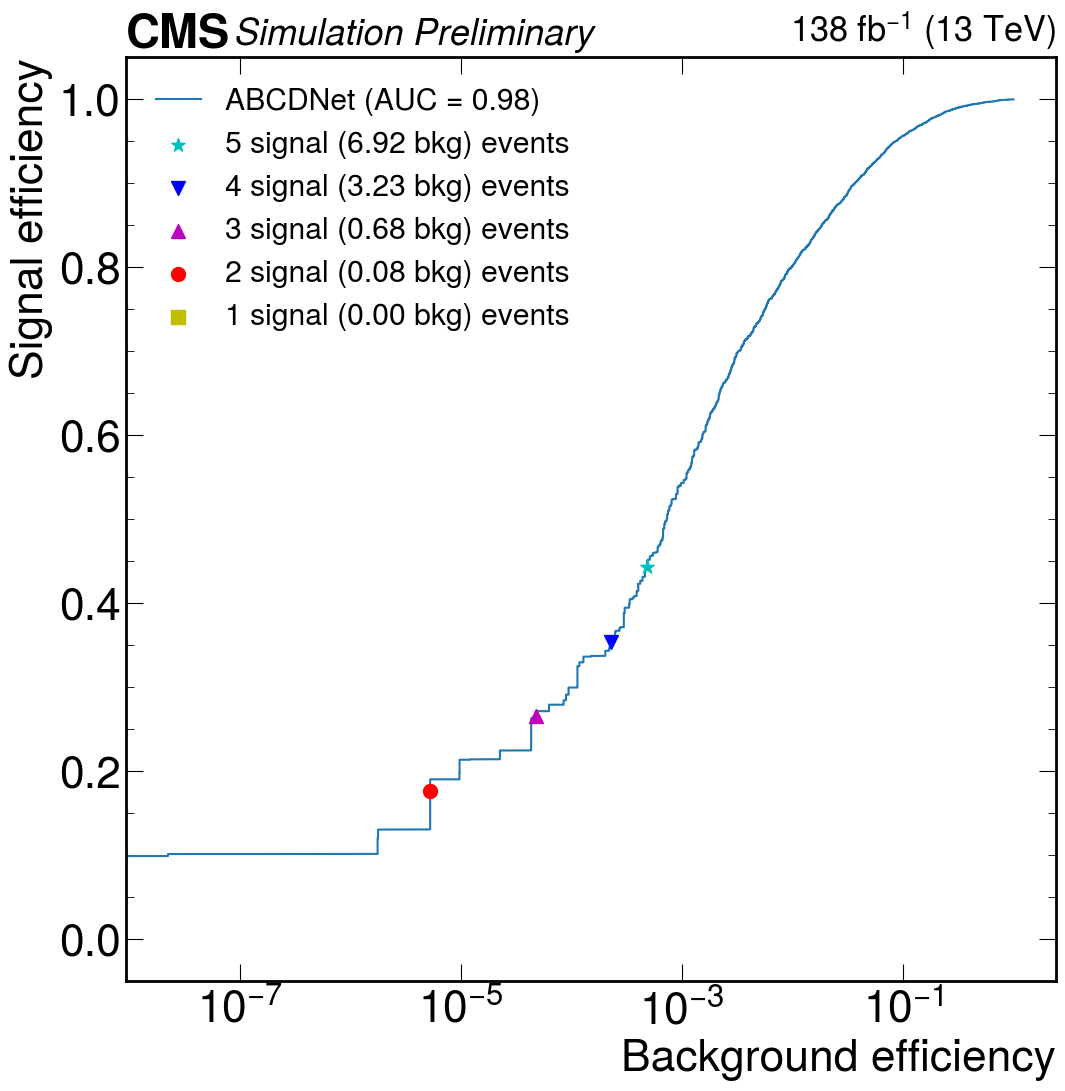

In [19]:
# plt.style.use("default")
# plt.rcParams.update({"figure.facecolor":  (1,1,1,0)})

from sklearn.metrics import roc_curve

df = vbsvvh.df[~vbsvvh.df.is_data]

selection = df.eval(
    "presel"
)

fpr, tpr, thresh = roc_curve(
    df[selection].is_signal, 
    df[selection].abcdnet_score, 
    sample_weight=df[selection].event_weight
)

fig, axes = plt.subplots(figsize=(12, 12))
axes.plot(fpr, tpr, label=f"ABCDNet (AUC = {np.trapz(tpr, fpr):.2f})");

total_sig = df[selection & (df.is_signal)].event_weight.sum()
total_bkg = df[selection & (~df.is_signal)].event_weight.sum()

axes.scatter(fpr[tpr >= 5/total_sig][0], tpr[tpr >= 5/total_sig][0], marker="*", s=100, zorder=104, color="c", label=f"5 signal ({fpr[tpr >= 5/total_sig][0]*total_bkg:0.2f} bkg) events");
axes.scatter(fpr[tpr >= 4/total_sig][0], tpr[tpr >= 4/total_sig][0], marker="v", s=100, zorder=103, color="b", label=f"4 signal ({fpr[tpr >= 4/total_sig][0]*total_bkg:0.2f} bkg) events");
axes.scatter(fpr[tpr >= 3/total_sig][0], tpr[tpr >= 3/total_sig][0], marker="^", s=100, zorder=102, color="m", label=f"3 signal ({fpr[tpr >= 3/total_sig][0]*total_bkg:0.2f} bkg) events");
axes.scatter(fpr[tpr >= 2/total_sig][0], tpr[tpr >= 2/total_sig][0], marker="o", s=100, zorder=101, color="r", label=f"2 signal ({fpr[tpr >= 2/total_sig][0]*total_bkg:0.2f} bkg) events");
axes.scatter(fpr[tpr >= 1/total_sig][0], tpr[tpr >= 1/total_sig][0], marker="s", s=100, zorder=100, color="y", label=f"1 signal ({fpr[tpr >= 1/total_sig][0]*total_bkg:0.2f} bkg) events");

# axes.scatter(fpr[tpr >= 3.73/total_sig][0], tpr[tpr >= 3.73/total_sig][0], marker="*", s=800, zorder=100, color="r", label=f"3.73 signal ({fpr[tpr >= 3.73/total_sig][0]*total_bkg:0.2f} bkg) events");

axes.tick_params(axis="both", which="both", direction="in", labelsize=32, top=True, right=True)
axes.set_xlabel("Background efficiency", size=32)
axes.set_ylabel("Signal efficiency", size=32)

# axes.legend(fontsize=18);
axes.legend()
plt.savefig(f"{PLOTSDIR}/abcdnet_roc.png")
plt.savefig(f"{PLOTSDIR}/abcdnet_roc.pdf")
print(f"Wrote to {PLOTSDIR}/abcdnet_roc.pdf")

axes.set_xscale("log")
plt.savefig(f"{PLOTSDIR}/abcdnet_roc_logx.png")
plt.savefig(f"{PLOTSDIR}/abcdnet_roc_logx.pdf")
print(f"Wrote to {PLOTSDIR}/abcdnet_roc_logx.pdf")

# plt.style.use(hep.style.CMS)

hep.cms.label(
    "Preliminary", 
    data=False, 
    lumi=vbsvvh.lumi, 
    loc=0, ax=axes, 
#     fontsize=None # set value here if needed
);